In [26]:
import numpy as np
from PIL import Image
from math import sqrt
from numpy.linalg import norm
from random import normalvariate
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
from tqdm import tqdm
import warnings
from sklearn.datasets import load_digits
warnings.filterwarnings('ignore')

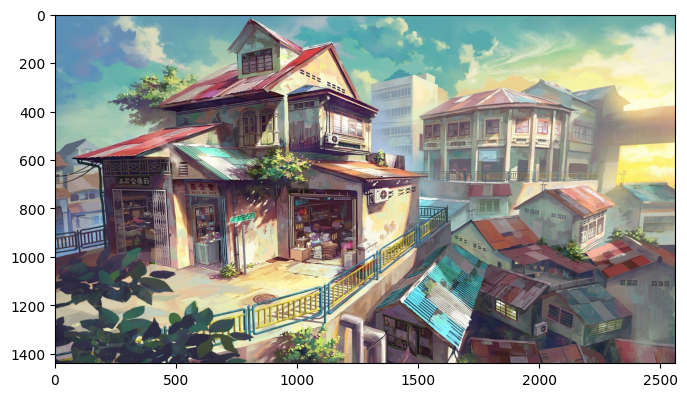

In [183]:
# Stocam imaginea
image = Image.open('wp1842933.jpg')

# Afisam imagiea
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()

In [184]:
def random_unit_vector(size):
    unnormalized = [normalvariate(0, 1) for _ in range(size)]
    norm = sqrt(sum(v * v for v in unnormalized))
    return [v / norm for v in unnormalized]
 
def power_iterate(X, epsilon=1e-10):    
    """ Recursively compute X^T X dot v to compute weights vector/eignevector """
 
    n, m = X.shape
    start_v = random_unit_vector(m) # Inceput aleatoriu
    prev_eigenvector = None
    curr_eigenvector = start_v
    covariance_matrix = np.dot(X.T, X)
 
    ## power iterationn until converges
    it = 0        
    while True:
        it += 1
        prev_eigenvector = curr_eigenvector
        curr_eigenvector = np.dot(covariance_matrix, prev_eigenvector)
        curr_eigenvector = curr_eigenvector / norm(curr_eigenvector)
 
        if abs(np.dot(curr_eigenvector, prev_eigenvector)) > 1 - epsilon:            
            return curr_eigenvector

def svd(X, epsilon=1e-10):
    """after computed change of basis matrix from power iteration, compute distance"""
    n, m = X.shape
    change_of_basis = []
 
    for i in range(m):
        data_matrix = X.copy()
 
        for sigma, u, v in change_of_basis[:i]:
            data_matrix = data_matrix - sigma * np.outer(u, v)
 
        v = power_iterate(data_matrix, epsilon=epsilon) ## vector propriu 
        u_sigma = np.dot(X, v) ## 2nd step: XV = U Sigma 
        sigma = norm(u_sigma)  
        u = u_sigma / sigma
 
        change_of_basis.append((sigma, u, v))
     
    sigmas, us, v_transposes = [np.array(x) for x in zip(*change_of_basis)]
 
    return sigmas, us.T, v_transposes 

In [17]:
def svd_compressor(image, order, name):
    #Intoarce imaginea compresata la rankul specificat
    
    #Cream un vector plin cu 0 sub forma imaginii
    Ak = np.zeros(image.shape)
    
    #Aflam U, S (sigma) si V folosind functia din python
    [U, S, V] = np.linalg.svd(image)

    #Afisarea valorilor singulare
    fig3=plt.figure(1)
    plt.semilogy(S)
    plt.title(f'{name}')
    plt.show()

    #Afisarea procentajului de informatie
    fig4 = plt.figure(2)
    plt.plot(np.cumsum(S) / np.sum(S))
    plt.title(f'{name}')
    plt.show()
    
    #Reconstruirea imaginii
    for i in range(order):
        Ak = U[:,:i] @ np.diag(S[:i]) @ V[:i, :]
        
    return Ak

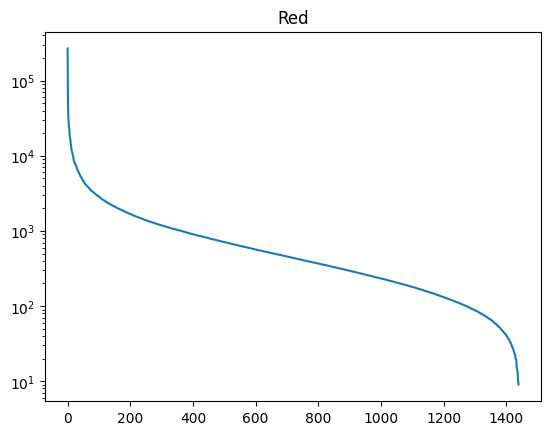

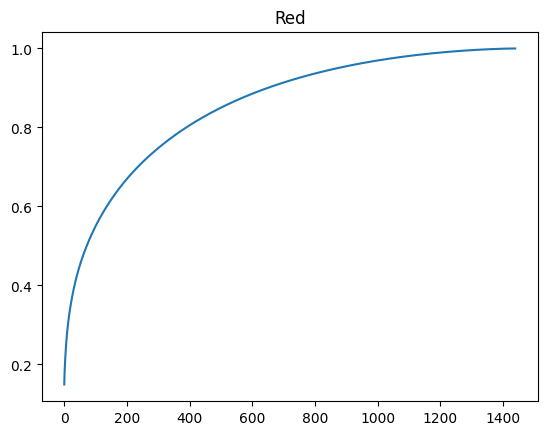

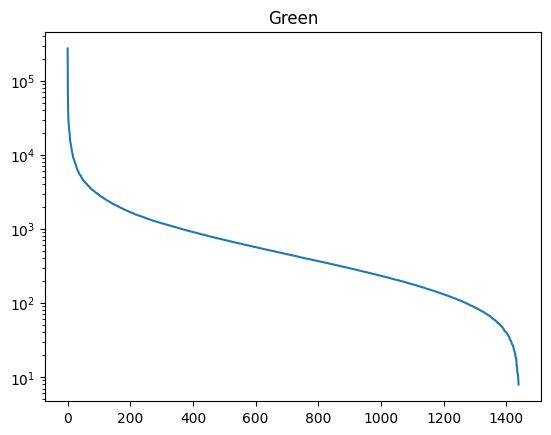

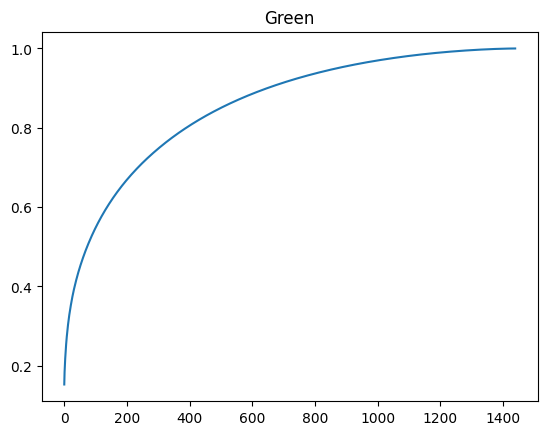

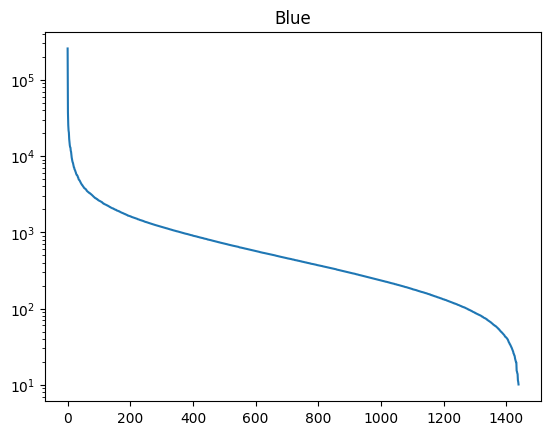

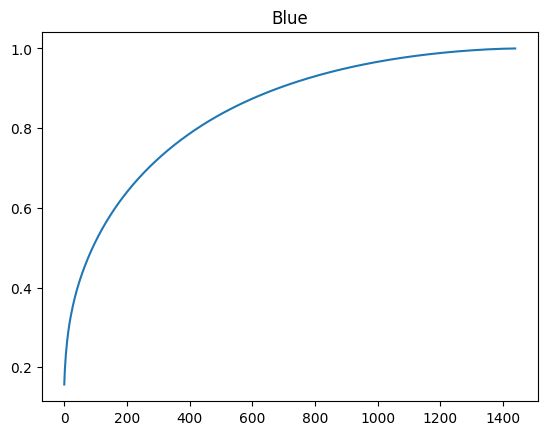

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


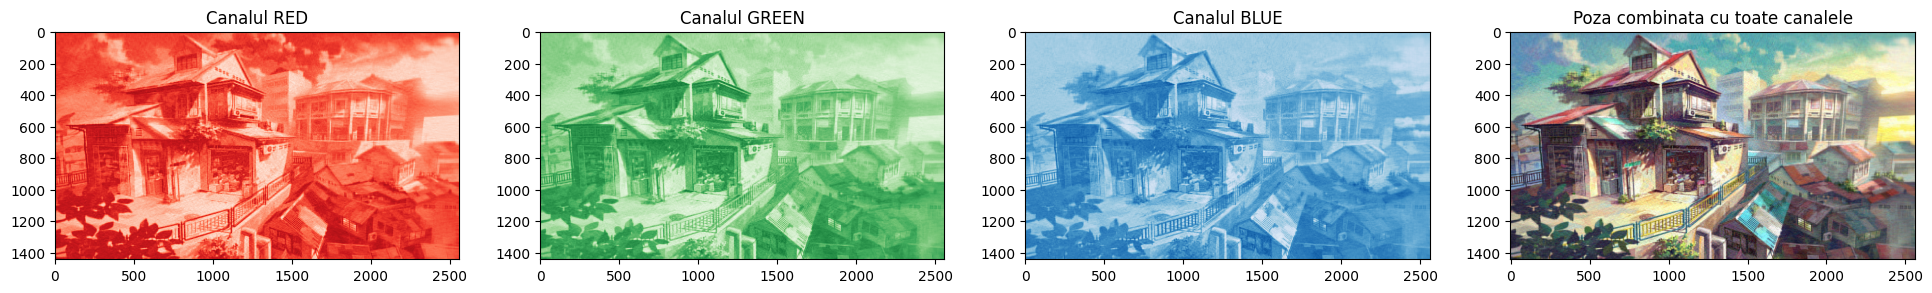

In [18]:
#Separarea canalelor RGB (red, green, blue)
red_image = np.array(image)[:, :, 0]
green_image = np.array(image)[:, :, 1]
blue_image = np.array(image)[:, :, 2]

#Compresie pe fiecare canal
order = 100
red_comp = svd_compressor(red_image, order,'Red')
green_comp = svd_compressor(green_image, order,'Green')
blue_comp = svd_compressor(blue_image, order,'Blue')

#Recombinam fiecare canal in imaginea orginala
color_comp = np.zeros((np.array(image).shape[0], np.array(image).shape[1], 3))
color_comp[:, :, 0] = red_comp
color_comp[:, :, 1] = green_comp
color_comp[:, :, 2] = blue_comp
color_comp = np.around(color_comp).astype(int)

#Afisarea fiecarui canal separat
#RED
plt.figure(figsize=(24, 8))
plt.subplot(141)
plt.imshow(red_comp, cmap='Reds_r')
plt.title("Canalul RED")
#GREEN
plt.subplot(142)
plt.imshow(green_comp, cmap='Greens_r')
plt.title("Canalul GREEN")
#BLUE
plt.subplot(143)
plt.imshow(blue_comp, cmap='Blues_r')
plt.title("Canalul BLUE")
#POZA FINALA
plt.subplot(144)
plt.imshow(color_comp)
plt.title("Poza combinata cu toate canalele")
plt.show()

100%|██████████| 9/9 [04:38<00:00, 31.00s/it]


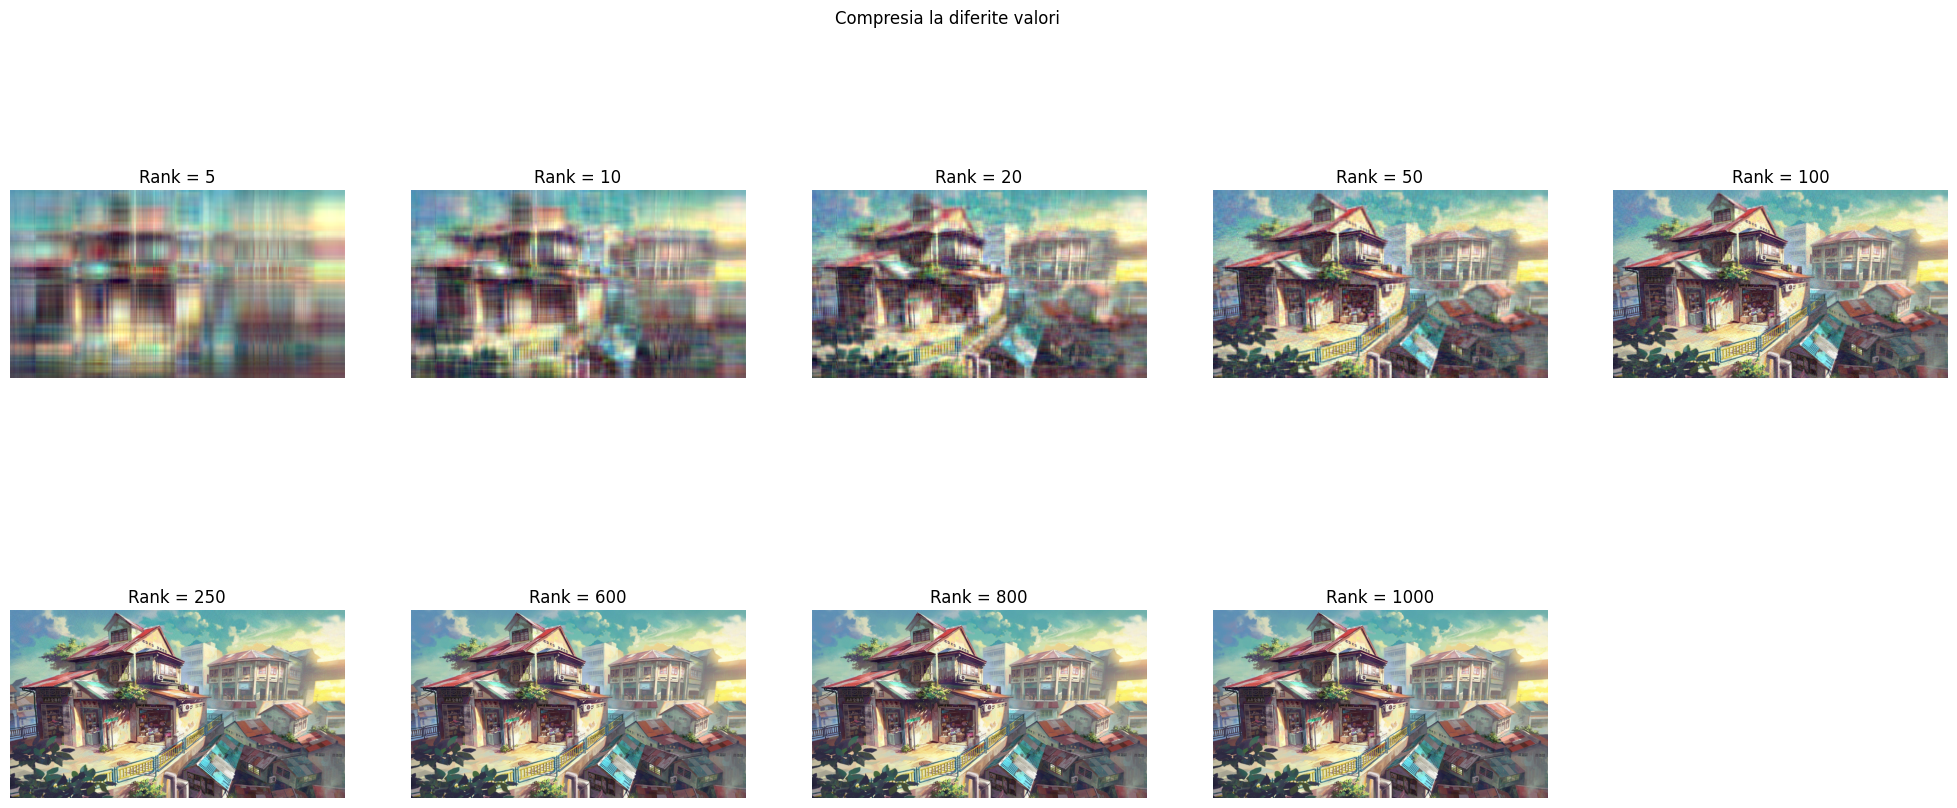

In [192]:
plt.figure(figsize=(25, 10))

#Vectori de valori singulare
orders = [5, 10, 20, 50, 100, 250, 600, 800, 1000]

for i in tqdm(range(len(orders))):
    
    #Folosim din nou functia de compresie
    order = orders[i]
    red_comp = svd_compressor(red_image, order)
    green_comp = svd_compressor(green_image, order)
    blue_comp = svd_compressor(blue_image, order)
    
    #Combinam imaginea
    color_comp = np.zeros((np.array(image).shape[0], np.array(image).shape[1], 3))
    color_comp[:, :, 0] = red_comp
    color_comp[:, :, 1] = green_comp
    color_comp[:, :, 2] = blue_comp
    color_comp = np.around(color_comp).astype(int)
    
    #Afisam imaginea pentru fiecare element din vector
    plt.subplot(2, 5, i + 1)
    plt.title("Rank = {}".format(order))
    plt.axis('off')
    plt.imshow(color_comp)

plt.suptitle('Compresia la diferite valori')
plt.show()

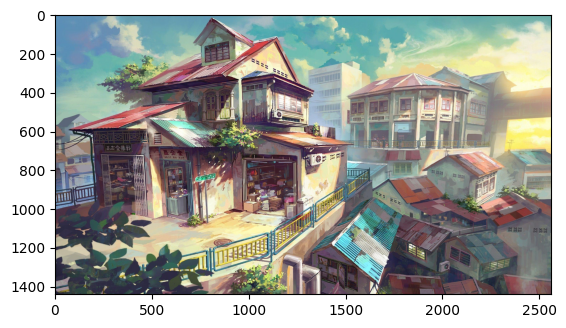

In [22]:
import cv2
img = cv2.cvtColor(cv2.imread('wp1842933.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

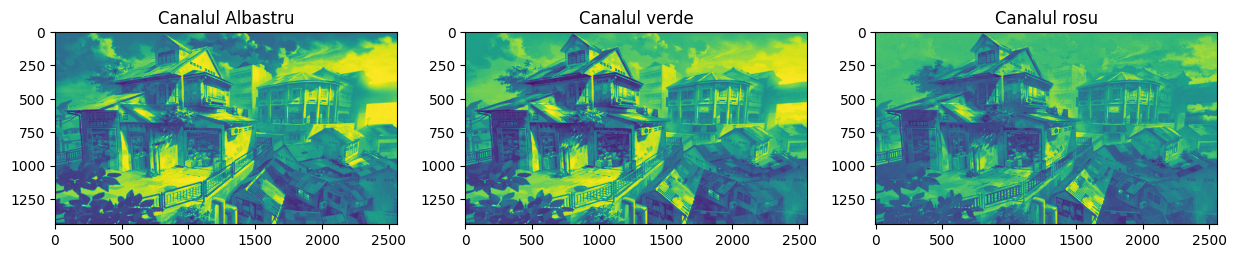

In [23]:
#Impartim pentru fiecare canal
blue,green,red = cv2.split(img)
# Afisam imaginea, fiecare afisare ne va arata cantitatea de culoare continuta in poza
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Canalul Albastru")
plt.imshow(blue)
fig.add_subplot(132)
plt.title("Canalul verde")
plt.imshow(green)
fig.add_subplot(133)
plt.title("Canalul rosu")
plt.imshow(red)
plt.show()

In [24]:
import pandas as pd
#exemplu de matrice pentru canalul albastru
blue_temp_df = pd.DataFrame(data = blue)
blue_temp_df

0     1     2     3     4     5     6     7     8     9     ...  2550  \
0      100    99    98    98    97    97    98    98   102   102  ...   118   
1       98    97    96    95    95    95    95    96    95    94  ...   114   
2       97    97    96    95    94    95    95    95    95    94  ...   113   
3       99    99    98    97    96    96    97    97    98    97  ...   115   
4       99    98    97    96    96    96    96    97    96    95  ...   116   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1435    32    29    26    24    25    26    26    26    27    28  ...   105   
1436    29    26    24    23    26    27    28    27    30    32  ...   105   
1437    27    25    24    24    28    29    29    28    32    32  ...   106   
1438    25    24    24    25    29    31    31    30    34    36  ...   106   
1439    24    23    24    26    31    32    33    32    39    39  ...   107   

      2551  2552  2553  2554  2555  2556  2557  2558  2559  
0      117   119   120   121   120   119   119   121   123  
1      114   117   118   119   118   117   117   119   122  
2      112   116   117   117   117   116   116   118   120  
3      115   115   116   117   116   115   116   118   120  
4      116   116   117   118   117   116   116   118   120  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
1435   103   106   102    99   100   104   103    96    91  
1436   103   106   102    99    99   104   104    98    91  
1437   104   105   103   100    99   101   101    98    95  
1438   105   105   103   101    98    98    99    99    99  
1439   106   104   104   102    98    96    95   100   102  

[1440 rows x 2560 columns]

In [35]:
digits = load_digits()
data = digits.data
data.shape
Pca = PCA(50) # we need 2 principal components.

 
converted_data.shape
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 15,
            cmap = c_map , c = digits.target)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

NameError: name 'converted_data' is not defined

In [28]:
#vom imparti fiecare canal la 255 pentru a obtine o scalare intre 0 si 1
df_blue = blue/255
df_green = green/255
df_red = red/255

In [29]:
#redefinim marimea matricei cu dimensiunea de 600
pca_b = PCA(n_components=600)
pca_b.fit(df_blue)
trans_pca_b = pca_b.transform(df_blue)
pca_g = PCA(n_components=600)
pca_g.fit(df_green)
trans_pca_g = pca_g.transform(df_green)
pca_r = PCA(n_components=600)
pca_r.fit(df_red)
trans_pca_r = pca_r.transform(df_red)

#noile matrici imparite 
print(trans_pca_b.shape)
print(trans_pca_r.shape)
print(trans_pca_g.shape)

(1440, 600)
(1440, 600)
(1440, 600)


In [30]:
#verificam suma variatiei pentru ratia de 600 a componentelor PCA cu 600 de valori proprii, pentru fiecare canal
print(f"Blue Channel : {sum(pca_b.explained_variance_ratio_)}")
print(f"Green Channel: {sum(pca_g.explained_variance_ratio_)}")
print(f"Red Channel  : {sum(pca_r.explained_variance_ratio_)}")

Blue Channel : 0.9946483977608257
Green Channel: 0.9950453659274897
Red Channel  : 0.9924672102650421


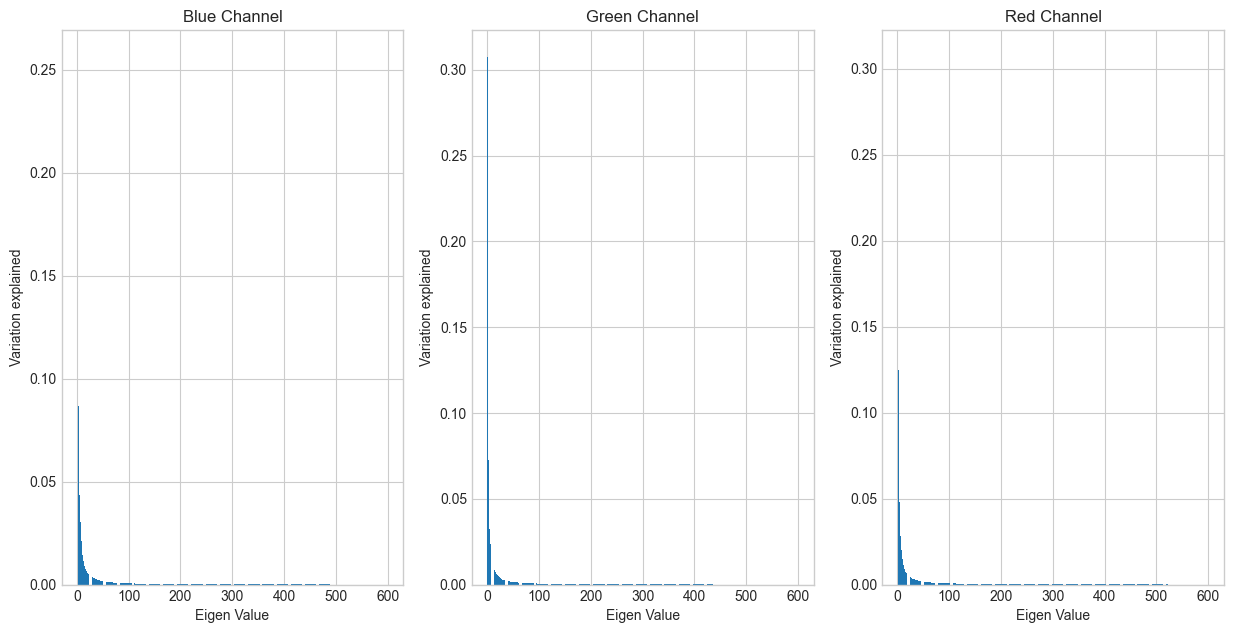

In [277]:
#observam ca pentru 600 de componenta pastram 99% din datele pozei
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
#vom afisa urmatoarele grafice pentru a vedea variatia ratiei pentru fiecare valoare libera a fiecarui canal
plt.title("Blue Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')s
plt.bar(list(range(1,601)),pca_b.explained_variance_ratio_)
fig.add_subplot(132)
plt.title("Green Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,601)),pca_g.explained_variance_ratio_)
fig.add_subplot(133)
plt.title("Red Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,601)),pca_r.explained_variance_ratio_)
plt.show()

In [31]:
#reconstruim matricile la forma initiala
b_arr = pca_b.inverse_transform(trans_pca_b)
g_arr = pca_g.inverse_transform(trans_pca_g)
r_arr = pca_r.inverse_transform(trans_pca_r)
print(b_arr.shape, g_arr.shape, r_arr.shape)

(1440, 2560) (1440, 2560) (1440, 2560)


(1440, 2560, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


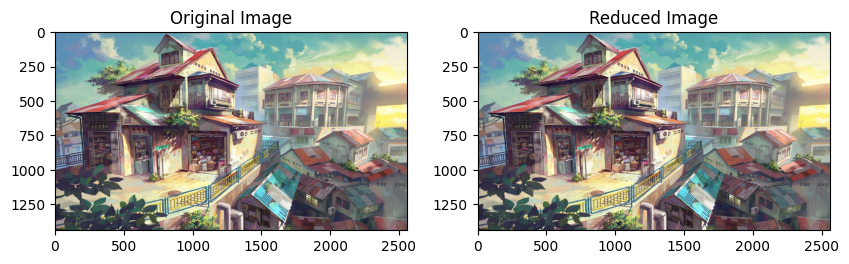

In [32]:
#reconstruim toate canalele intr-un singur canal 
img_reduced= (cv2.merge((b_arr, g_arr, r_arr)))
print(img_reduced.shape)
fig = plt.figure(figsize = (10, 7.2)) 
fig.add_subplot(121)
plt.title("Imagine Originala")
plt.imshow(img)
fig.add_subplot(122)
plt.title("Imagine Redusa")
plt.imshow(img_reduced)
plt.show()